A Stock Price Predictor based on LSTM model.

Importing the libraries

In [74]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ta

Downloading the data and checking if the correct data is downloaded

In [96]:
# 1) Download and subset
raw = yf.download('NVDA', start='2015-01-01', end='2024-12-31')
raw = raw[['Open','High','Low','Close','Volume']]
if isinstance(raw.columns, pd.MultiIndex):
    raw.columns = raw.columns.get_level_values(0)

# 2) Compute SMA & EMA
raw['SMA_20'] = raw['Close'].rolling(window=20).mean()
raw['EMA_20'] = raw['Close'].ewm(span=20, adjust=False).mean()

# 3) Compute RSI on a true 1-D Series
close_s = raw['Close'].squeeze()            # ensure it’s a Series
raw['RSI_14'] = ta.momentum.RSIIndicator(close=close_s, window=14).rsi()

raw['dayofweek'] = raw.index.dayofweek
raw['month']    = raw.index.month
raw['dow_sin'] = np.sin(2 * np.pi * raw['dayofweek'] / 7)
raw['dow_cos'] = np.cos(2 * np.pi * raw['dayofweek'] / 7)
raw['mon_sin'] = np.sin(2 * np.pi * (raw['month'] - 1) / 12)
raw['mon_cos'] = np.cos(2 * np.pi * (raw['month'] - 1) / 12)

# 4) Drop NaNs, scale, build sequences…
raw = raw.dropna()


[*********************100%***********************]  1 of 1 completed


Plotting the data

Preprocessing of data by normalizing it. Only using closing price for now. 

In [97]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(raw)

Creating time series sequences for prediction. We will use past 60 days for now.

In [98]:
def create_sequences(data, seq_len=120):
    X, y = [], []
    for i in range(seq_len, len(data)):
        # X: past `seq_len` rows, all 8 features
        X.append(data[i-seq_len:i])
        # y: the next row’s Close price (index 3 in `raw.columns`)
        y.append(data[i, raw.columns.get_loc('Close')])
    return np.array(X), np.array(y)

sequence_length = 120
X, y = create_sequences(scaled_data, sequence_length)
print("X shape:", X.shape)  # (samples, 120, 8)
print("y shape:", y.shape)  # (samples,)

X shape: (2376, 120, 14)
y shape: (2376,)


Splitting data into testing and training data

In [99]:
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

Epoch 1/20


c:\Users\saksh\Desktop\Stock Price Predictor\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.1197 - val_loss: 2.5630
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0208 - val_loss: 3.0396
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0178 - val_loss: 3.0042
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0159 - val_loss: 3.0412
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0148 - val_loss: 3.1854
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0133 - val_loss: 3.3311


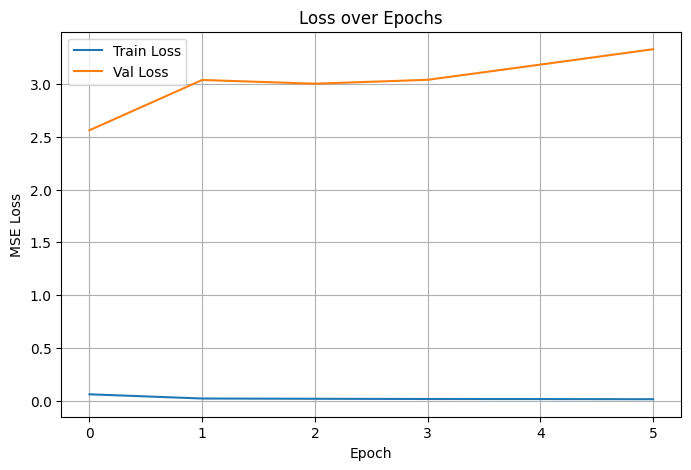

In [100]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense
from tensorflow.keras.regularizers import l2

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu',
           input_shape=(sequence_length, X.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    LSTM(50, return_sequences=False,
         kernel_regularizer=l2(1e-4)),
    Dropout(0.2),

    Dense(25, activation='relu', kernel_regularizer=l2(1e-4)),
    Dense(1)   # final raw price
])

model.compile(optimizer='adam', loss='mean_squared_error')


# 6) Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop]
)

# 7) Plot training & validation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


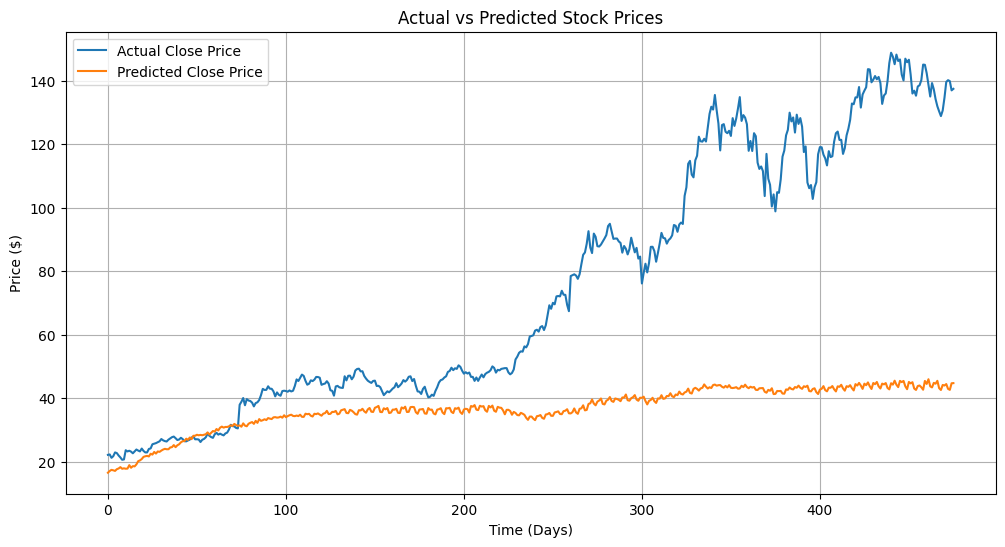

Root Mean Squared Error: 51.60


In [102]:
from sklearn.metrics import mean_squared_error

# 1) Predict on the test set (standardized Close values)
y_pred_scaled = model.predict(X_test)        # shape (n_test_samples, 1)
y_true_scaled = y_test.reshape(-1, 1)        # shape (n_test_samples, 1)

# 2) Invert the scaling for the 'Close' feature
#    We need to rebuild full feature arrays with only the Close column nonzero,
#    then inverse_transform via our scaler to recover the original price.

# Find the index of 'Close' in raw.columns
close_idx = raw.columns.get_loc('Close')  # now returns 3
close_idx = list(raw.columns).index('Close')

# Create placeholders for inverse transform
n_test = y_pred_scaled.shape[0]
dummy = np.zeros((n_test, raw.shape[1]))     # raw.shape[1] == 8 features

# Fill the Close column
dummy = np.zeros((n_test, raw.shape[1]))
dummy[:, close_idx] = y_pred_scaled[:, 0]
pred_inverted = scaler.inverse_transform(dummy)[:, close_idx]

dummy[:, close_idx] = y_true_scaled[:, 0]
true_inverted = scaler.inverse_transform(dummy)[:, close_idx]
# 3) Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(true_inverted, label='Actual Close Price')
plt.plot(pred_inverted, label='Predicted Close Price')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time (Days)')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

# 4) Compute RMSE
rmse = np.sqrt(mean_squared_error(true_inverted, pred_inverted))
print(f"Root Mean Squared Error: {rmse:.2f}")
